In [1]:
import numpy as np
import WLCgreen as wlc
import propagator 
import special as sp
from numba import jit
import MultiPoint as mp

import matplotlib.pyplot as plt
#%matplotlib
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [2]:
def plotlog(x, y, alpha, xrange=1, numx=2):
    xv = np.logspace(np.log10(x), np.log10(x) + xrange, numx)
    C = y / (x**alpha)
    yv = C * xv**(alpha)
    plt.loglog(xv, yv,'k--')

## 2 point

In [3]:
nlam=3
ORDEig=25
d=3
mu=0

nkpts=500
K=np.logspace(-5,7,nkpts)
props=[] # list of propagators at each K
for ii in range(0,nkpts):
    name = ii
    props.append(propagator.propagator(name,K[ii],mu,nlam=nlam))

### AA

In [4]:
fa=0.5
N=[0.1,1.0,10,100,1000,10000,100000]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
for ii in range(0,nkpts):
    lam=0
    lam0=0
    for nn in range(0,len(N)):
        ana[ii,nn]=mp.IAAresum(N[nn],fa,lam0,lam,props[ii])
        dub[ii,nn]=mp.IAAexplicit(N[nn],fa,lam0,lam,props[ii])

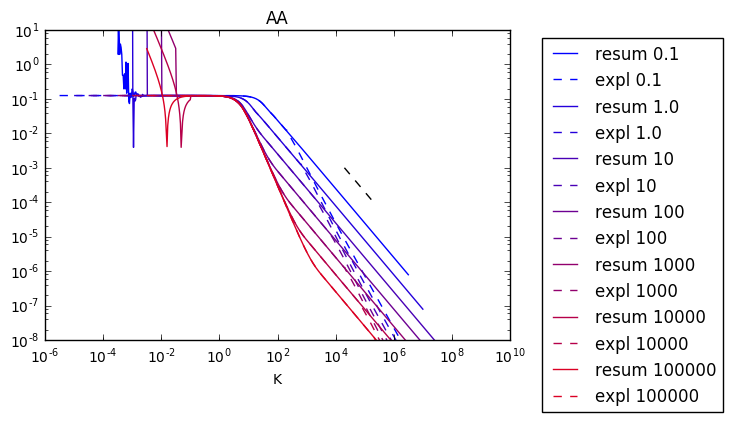

In [5]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real*np.sqrt(N[ii]),abs(ana[:,ii])/(N[ii]**2),\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    ax.loglog(K.real*np.sqrt(N[ii]),abs(dub[:,ii])/(N[ii]**2),'--',\
                color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
plotlog(2e4,1e-3,-1) 
ax.set_xlabel('K')
ax.set_title('AA')
ax.set_ylim([10**-8,10**1])
plt.show()

In [6]:
N=[0.01,0.1,1.0,10,100]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
fa=0.5
for ii in range(0,nkpts):
    lam=0
    lam0=0
    for nn in range(0,len(N)):
        ana[ii,nn]=mp.IABresum(N[nn],fa,lam0,lam,props[ii])
        dub[ii,nn]=mp.IABexplicit(N[nn],fa,lam0,lam,props[ii])

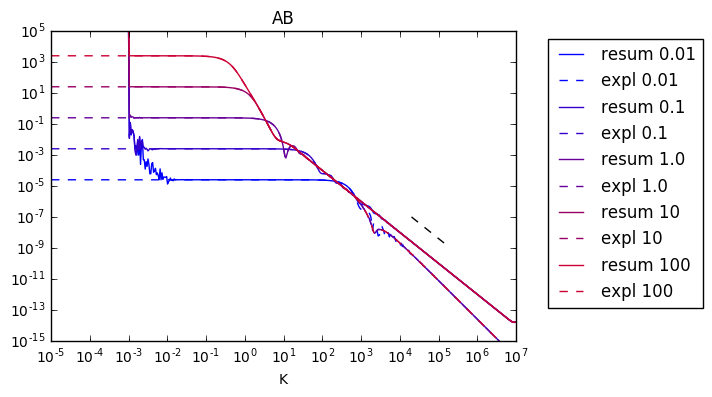

In [7]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real,abs(ana[:,ii]),\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    ax.loglog(K.real,abs(dub[:,ii]),'--',\
                color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
plotlog(2e4,1e-7,-2)
ax.set_xlabel('K')
ax.set_title('AB')
ax.set_ylim([10**-15,100000])
plt.show()

## 3 Point

In [8]:
nlam=5
ORDEig=10
d=3
mu=0

nkpts=100
K=np.logspace(-4,7,nkpts)
props1=[] # list of propagators at each K
props2=[] # list of propagators at each K
for ii in range(0,nkpts):

    name=ii
    props1.append( propagator.propagator(name,K[ii],mu,nlam=nlam) )

    name=ii+0.5
    props2.append( propagator.propagator(name,K[ii],mu,nlam=nlam) )

#### AAA

In [9]:
N=[0.01,0.1,1.0,10,100]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
#dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
for ii in range(0,nkpts):
    lam_1=0
    lam0_1=0
    lam_2=0
    lam0_2=0
    for nn in range(0,len(N)):
        #IAAAexplicit(N,fa,lam0_1,lam_1,lam0_2,lam_2,p1,p2)
        ana[ii,nn]=mp.IAAAresum(N[nn],fa,\
                                lam0_1,lam_1,\
                                lam0_2,lam_2,\
                                props1[ii],props2[ii])
        #dub[ii,nn]=np.IAAAexplicit(N[nn],lam0,lam,props1[ii],props2[ii])

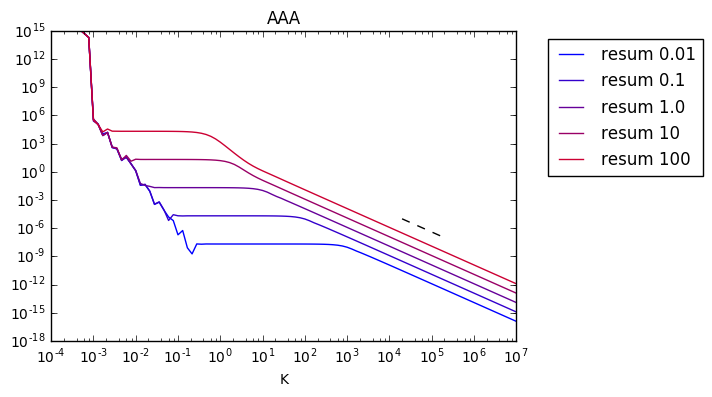

In [10]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real,abs(ana[:,ii]),\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    #ax.loglog(K.real,abs(dub[:,ii]),'--',\
    #            color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
plotlog(2e4,1e-5,-2)
ax.set_xlabel('K')
ax.set_title('AAA')
ax.set_ylim([10**-18,10**15])
plt.show()

#### ABB

In [11]:
N=[0.01,0.1,1.0,10,100]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
fa=0.4466
for ii in range(0,nkpts):
    lam_1=0
    lam0_1=0
    lam_2=0
    lam0_2=0
    for nn in range(0,len(N)):
        ana[ii,nn]=mp.IABBresum(N[nn],fa,\
                                lam0_1,lam_1,\
                                lam0_2,lam_2,\
                                props1[ii],props2[ii])
        #dub[ii,nn]=IAAAexplicit(N[nn],lam0,lam,props1[ii],props2[ii])

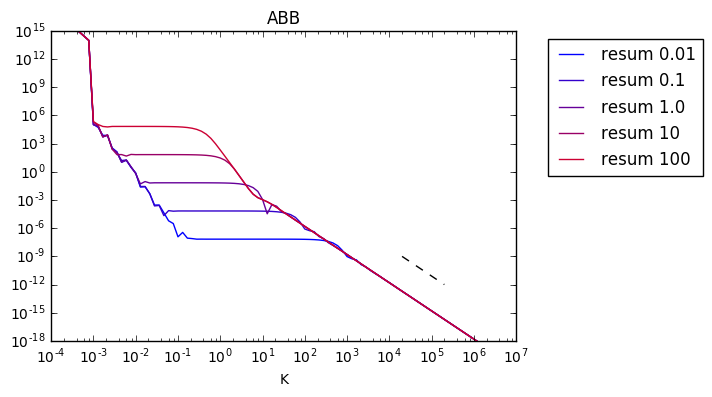

In [12]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real,abs(ana[:,ii]),\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    #ax.loglog(K.real,abs(dub[:,ii]),'--',\
    #            color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
ax.legend(bbox_to_anchor=(1.05,1),loc=2)
plotlog(2e4,1e-9,-3)
ax.set_xlabel('K')
ax.set_title('ABB')
ax.set_ylim([10**-18,10**15])
plt.show()

## 4 point

In [4]:
nlam=5
ORDEig=25
d=3
mu1=0
mu2=1
mu3=0

nkpts=100
K=np.logspace(-2,5,nkpts)
props1=[] # list of propagators at each K
props2=[] # list of propagators at each K
props3=[] # list of propagators at each K
for ii in range(0,nkpts):

    name=ii
    props1.append( propagator.propagator(name,1.0*K[ii],mu1,nlam=nlam) )

    name=ii+0.5
    props2.append( propagator.propagator(name,2.0*K[ii],mu2,nlam=nlam) )
    
    name=ii+0.25
    props3.append( propagator.propagator(name,1.0*K[ii],mu3,nlam=nlam) )

In [19]:
N=[0.001,0.01,0.1,1.0,10,100,1000]
ana=np.zeros((nkpts,len(N)),dtype=type(1+1j))
dub=np.zeros((nkpts,len(N)),dtype=type(1+1j))
fa=0.4466
for ii in range(0,nkpts):
    lam_1=0
    lam0_1=2
    lam_2=2
    lam0_2=1    
    lam_3=1
    lam0_3=0
    
    for nn in range(0,len(N)):
        ana[ii,nn]=mp.IAAAAresum(N[nn],fa,\
                                 lam0_1,lam_1,\
                                 lam0_2,lam_2,\
                                 lam0_3,lam_3,\
                                 props1[ii],props2[ii],props3[ii])
        if np.isnan(ana[ii,nn]):
            print('Nan Found')
        #dub[ii,nn]=mp.IAAAAexplicit(N[nn],fa,\
        #                         lam0_1,lam_1,\
        #                         lam0_2,lam_2,\
        #                         lam0_3,lam_3,\
        #                         props1[ii],props2[ii],props3[ii])

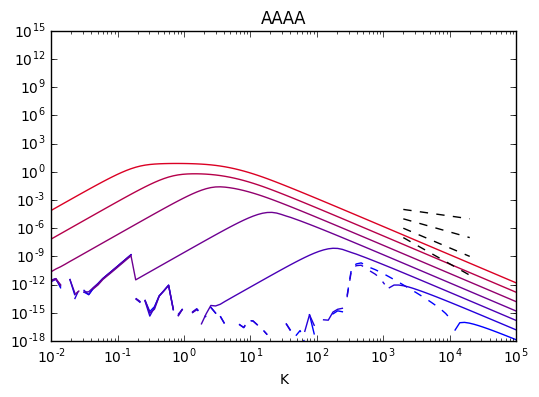

In [7]:
fig, ax = plt.subplots()
for ii in range(0,len(N)):
    col=float(ii)/len(N)
    ax.loglog(K.real,ana[:,ii].real,'-',\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    ax.loglog(K.real,-ana[:,ii].real,'--',\
                color=[col, 0.0, 1-col],label='resum '+str(N[ii]))
    #ax.loglog(K.real,-dub[:,ii].real,':',\
    #            color=[col, 0.0, 1-col],label='expl '+str(N[ii]))
#ax.legend(bbox_to_anchor=(1.05,1),loc=2)
#ax.legend(bbox_to_anchor=(1.05,1))
plotlog(2e3,1e-4,-1)
plotlog(2e3,1e-5,-2)
plotlog(2e3,1e-6,-3)
plotlog(2e3,1e-7,-4)
ax.set_xlabel('K')
ax.set_title('AAAA')
ax.set_ylim([10**-18,10**15])
plt.show()